# Outline
## I. Mathematical Modeling
1. ODEs Model of the heterodimer formation system
2. Solve the equations and obtain analytical solution
   
## II. Data processing
1. Import Data
2. Set a cutoff to filter out data with saturated signal 
3. Exploring the Data by visualization 
4. Identify the linear range and eliminate data outside the range

## III. Model Fitting
1. Compare the difference between RFP and BFP
2. Estimate the cooperative stability by model fitting

In [1]:
import os 
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
import seaborn as sns
import time 

## I. Mathematical Modeling

### 1. Model construction

In [2]:
#Clearing formatting
init_printing(pretty_print=False)

#Components of the heterdimer formation system: p1 monomer, p2 monomer, and the heterdimer p3. 
p1 = Symbol('p1')
p2 = Symbol('p2')
p3 = Symbol('p3')
#Parameters of the heterdimer formation system: 
#lami (i=1, 2, 3) represents the degradation rate of corresponding protein
#K is the association constant
#ci (i=1, 2) represents the synthesis rate of corresponding protein
lam1 = Symbol('lam1')
lam2 = Symbol('lam2')
lam3 = Symbol('lam3')
K = Symbol('K')
c1 = Symbol('c1')
c2 = Symbol('c2')

#Assume association/dissociation rate >> degradation and production rate
#at steady state, we could write down the following equations to describe 
#the dynamic of the heterodimer formation system
eq1 = c1 - lam1*p1 - lam3*p3
eq2 = c2 - lam2*p2 - lam3*p3
eq3 = p3 - p1*p2*K

print(eq1)
print(eq2)
print(eq3)

c1 - lam1*p1 - lam3*p3
c2 - lam2*p2 - lam3*p3
-K*p1*p2 + p3


### 2. Solve the ODEs at the steady state

In [3]:
#Solve the ODEs at the steady state
ans1 = solve(eq3, p3) #p3
ans2 = solve([p3-ans1[0], eq1],[p1, p3]) 
ans3 = solve([p3-ans1[0], eq2],[p2, p3]) 
ans4 = solve([p2-ans3[p2], p1-ans2[p1]],[p1, p2]) #ans4[1](正號解) ans4[1][0]=p1, ans4[1][1]=p2
ans5 = solve([p3-ans3[p3], p1-ans4[1][0]],[p1, p3]) #ans5[0][1] p3

In [4]:
print('p1:\n', ans4[1][0], '\n')
print('p2:\n', ans4[1][1], '\n')
print('p3:\n', ans5[0][1], '\n')
print('p1+p3:\n', simplify(ans4[1][0]+ans5[0][1]))

p1:
 (K*c1*lam3 - K*c2*lam3 - lam1*lam2 + sqrt(K**2*c1**2*lam3**2 - 2*K**2*c1*c2*lam3**2 + K**2*c2**2*lam3**2 + 2*K*c1*lam1*lam2*lam3 + 2*K*c2*lam1*lam2*lam3 + lam1**2*lam2**2))/(2*K*lam1*lam3) 

p2:
 (-K*c1*lam3 + K*c2*lam3 - lam1*lam2 + sqrt(K**2*c1**2*lam3**2 - 2*K**2*c1*c2*lam3**2 + K**2*c2**2*lam3**2 + 2*K*c1*lam1*lam2*lam3 + 2*K*c2*lam1*lam2*lam3 + lam1**2*lam2**2))/(2*K*lam2*lam3) 

p3:
 c2*(K*c1*lam3 - K*c2*lam3 - lam1*lam2 + sqrt(K**2*c1**2*lam3**2 - 2*K**2*c1*c2*lam3**2 + K**2*c2**2*lam3**2 + 2*K*c1*lam1*lam2*lam3 + 2*K*c2*lam1*lam2*lam3 + lam1**2*lam2**2))/(lam3*(K*c1*lam3 - K*c2*lam3 + lam1*lam2 + sqrt(K**2*c1**2*lam3**2 - 2*K**2*c1*c2*lam3**2 + K**2*c2**2*lam3**2 + 2*K*c1*lam1*lam2*lam3 + 2*K*c2*lam1*lam2*lam3 + lam1**2*lam2**2))) 

p1+p3:
 (K*c1*lam3 - K*c2*lam3 - lam1*lam2 + sqrt(K**2*c1**2*lam3**2 - 2*K**2*c1*c2*lam3**2 + K**2*c2**2*lam3**2 + 2*K*c1*lam1*lam2*lam3 + 2*K*c2*lam1*lam2*lam3 + lam1**2*lam2**2))*(K*c1*lam3 + 2*K*c2*lam1 - K*c2*lam3 + lam1*lam2 + sqrt(K**2*c1

## II. Data Processing

### 1. Import data and filter out the data with saturated signal

In [5]:
#build a class
class FACS_data():
    
    def __init__(self, PATH):
        #Read data 
        gfp_ls = [] 
        rfp_ls = [] 
        bfp_ls = []

        with open(PATH, 'r') as f:
            lines = f.readlines()
            for i in range(1, len(lines)):
                gfp_, rfp_, bfp_ = lines[i].strip().split('\t')
                gfp_ls.append(float(gfp_))
                rfp_ls.append(float(rfp_))
                bfp_ls.append(float(bfp_))
            
        #Filter out maximum values
        g_max = max(gfp_ls)
        r_max = max(rfp_ls)
        b_max = max(bfp_ls)
        gfp_L = []
        rfp_L = []
        bfp_L = []
        
        for i in range(len(gfp_ls)):
            g_ = gfp_ls[i]
            r_ = rfp_ls[i]
            b_ = bfp_ls[i]
            if not (g_==g_max or r_==r_max or b_==b_max):
                gfp_L.append(g_)
                rfp_L.append(r_)
                bfp_L.append(b_)

        self.gfp = np.array(gfp_L)
        self.rfp = np.array(rfp_L)
        self.bfp = np.array(bfp_L)

In [13]:
RAD1_plus_HUS1 = FACS_data('data/GPS_RAD1_HUS1_for_testing.txt')
HUS1_plus_RAD1 = FACS_data('data/GPS_HUS1_RAD1_for_testing.txt')

### 2. Exploring the Data by visualization

In [14]:
#Explore the data by visualization
def scatter(x, y, label=['data'], title=None, path=None):
       
    linewidth = 7
    font2 = {
    'weight' : 'normal',
    'size'   : 20}
    colors = ['green', 'black']

    figure, ax = plt.subplots(figsize=(9, 6))
    if len(y) > 1 and len(y)<10:
        for i in range(len(y)):
            try:
                plt.plot(x[i], y[i], '.',label=label[i])
            except:
                plt.plot(x, y[i], '.', label=label[i])
    else:
        plt.plot(x, y, '.', label=label[0])

    plt.xlabel('mCherry', font2)
    plt.ylabel('GFP', font2)
    if title!=None:
        plt.title(title, font2)


    #ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    #ax.yaxis.set_major_locator(ticker.NullLocator())
    #ax.xaxis.set_major_locator(ticker.NullLocator())


    plt.tick_params(width=3, length=4, labelsize=12)
    #plt.grid()#網格

    ax1=plt.gca();
    ax_linewidth = 3
    ax1.spines['bottom'].set_linewidth(ax_linewidth);
    ax1.spines['left'].set_linewidth(ax_linewidth);
    ax1.spines['right'].set_linewidth(ax_linewidth);
    ax1.spines['top'].set_linewidth(ax_linewidth);

    plt.xlim(0, 70000)
    plt.ylim(0, 85000)

    #plt.legend(bbox_to_anchor=[1.3, 0.8])
    plt.legend()
    if path != None:
        plt.savefig(path)
    
    plt.show()
    
def distribution(a, log=True, title=None):
    a[a <= 0] = 1
    if log == True:
        sns.distplot(np.log10(a))
        plt.xlim(0, 6)
    else:
        sns.distplot(a)
        
    if title!=None: 
        plt.title(title) 
    plt.show()

def scatter_3D(data, title='RAD1 + HUS1', data_number=15000):
    fig = plt.figure(figsize=(10, 8))
    #ax = Axes3D(fig)
    ax = fig.add_subplot(projection='3d')
    
    x = data.rfp[:data_number]
    y = data.gfp[:data_number]
    z = data.bfp[:data_number]

    ax.scatter(x, y, z, s=2, c='b')
    plt.xlabel('mCherry')
    plt.ylabel('GFP')
    ax.set_zlabel('Pacific Blue', rotation=60)
    ax.view_init(30, 250)
    plt.show()

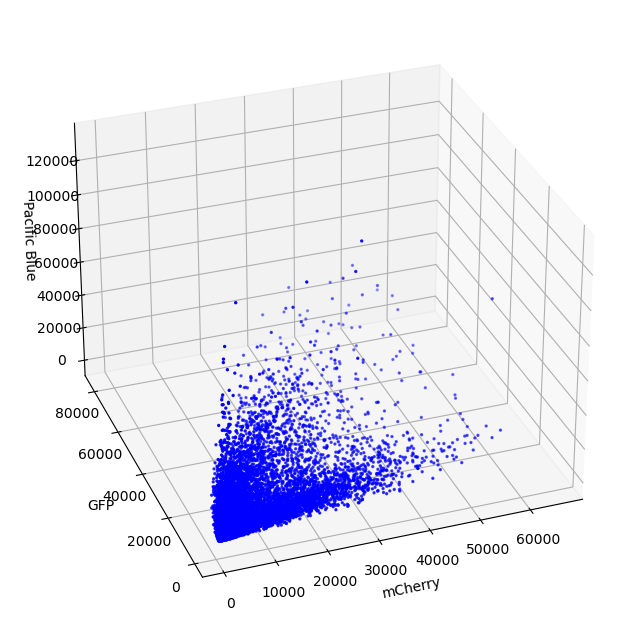

In [15]:
scatter_3D(RAD1_plus_HUS1)

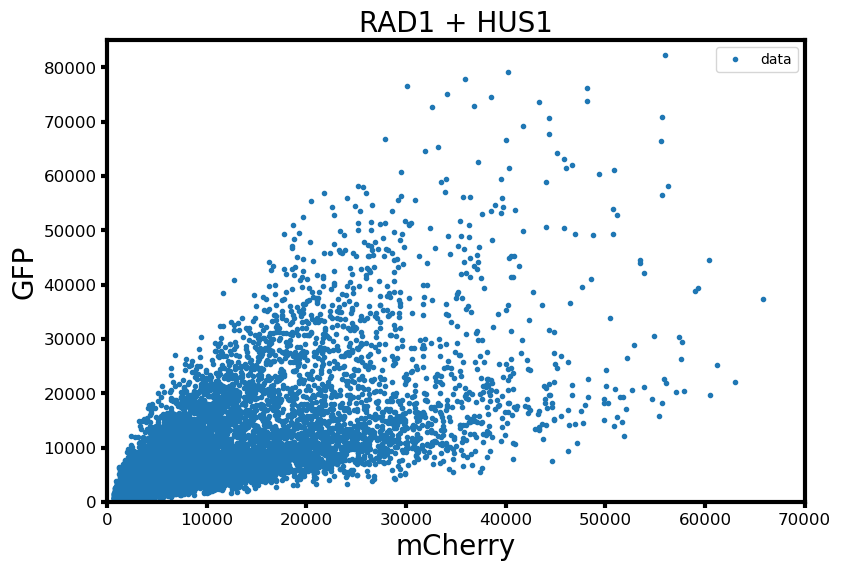

In [16]:
scatter(RAD1_plus_HUS1.rfp, RAD1_plus_HUS1.gfp, title='RAD1 + HUS1')

/Users/klhsu/miniforge3/envs/py38_native/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


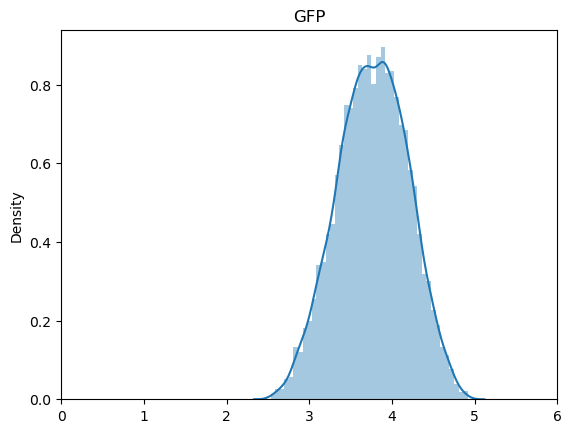

/Users/klhsu/miniforge3/envs/py38_native/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


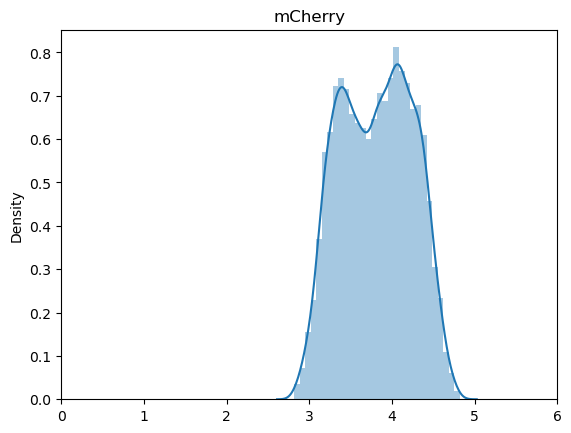

/Users/klhsu/miniforge3/envs/py38_native/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


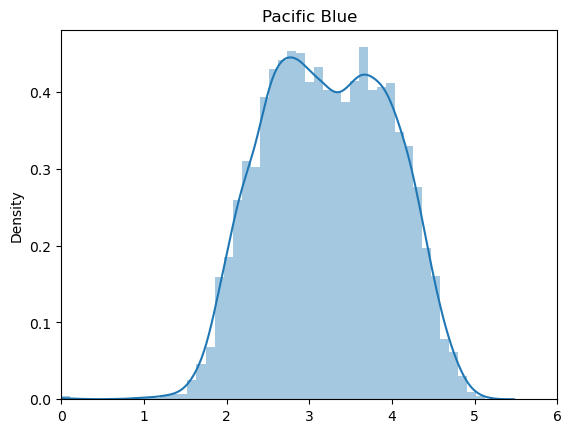

In [17]:
distribution(RAD1_plus_HUS1.gfp, title='GFP')
distribution(RAD1_plus_HUS1.rfp, title='mCherry')
distribution(RAD1_plus_HUS1.bfp, title='Pacific Blue')

### 3. Identify the linear range and eliminate data outside the range

In [18]:
def shift_data_and_update(data, cutoff=None):
    rfp = data.rfp
    gfp = data.gfp
    bfp = data.bfp
    
    mi_r = min(rfp)
    mi_g = min(gfp)
    mi_b = min(bfp)
    
    new_rfp, new_gfp, new_bfp = [], [], []
    for i in range(len(bfp)):
        key = bfp[i]
        if cutoff!=None:
            if key <= cutoff:
                new_rfp.append(rfp[i])
                new_gfp.append(gfp[i])
                new_bfp.append(bfp[i])
        else:
            new_rfp.append(rfp[i]-mi_r)
            new_gfp.append(gfp[i]-mi_g)
            new_bfp.append(bfp[i]-mi_b)  
            
    data.rfp = np.array(new_rfp)
    data.gfp = np.array(new_gfp)
    data.bfp = np.array(new_bfp)
    
def cut_data(data, mi, mx):
    rfp = data.rfp
    gfp = data.gfp
    bfp = data.bfp
    
    new_rfp, new_gfp, new_bfp = [], [], []
    for i in range(len(bfp)):
        key = bfp[i]
        if key > mi and key < mx:
            new_rfp.append(rfp[i])
            new_gfp.append(gfp[i])
            new_bfp.append(bfp[i])
    arr_rfp = np.array(new_rfp)
    arr_gfp = np.array(new_gfp)
    arr_bfp = np.array(new_bfp)
    return (arr_rfp, arr_gfp, arr_bfp)

### Shift the minimum to zero 

In [19]:
shift_data_and_update(RAD1_plus_HUS1)
shift_data_and_update(HUS1_plus_RAD1)

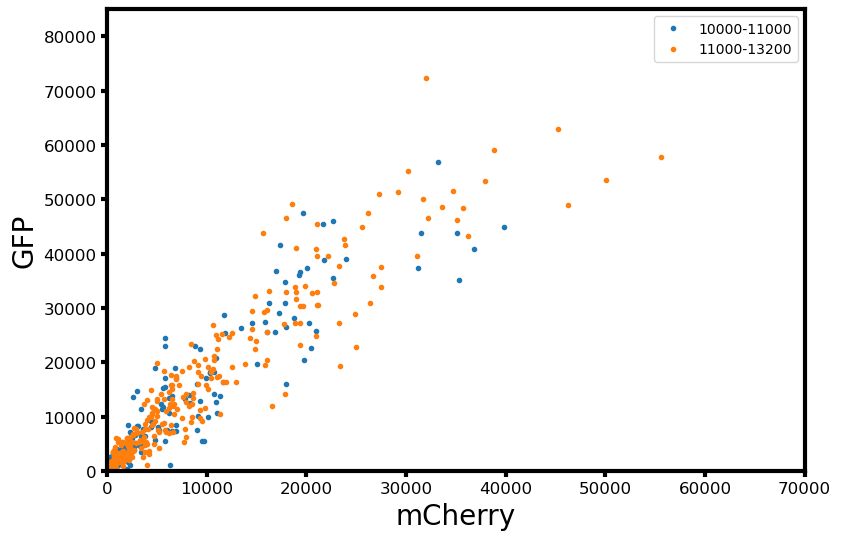

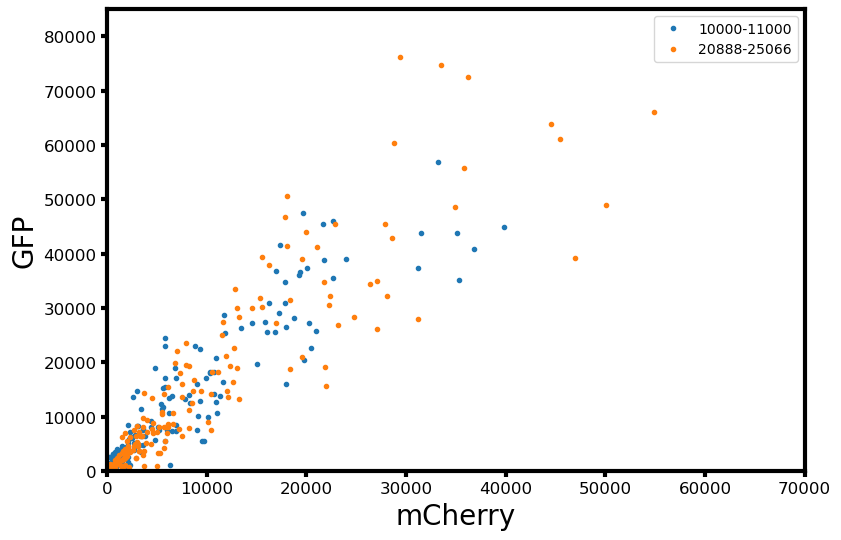

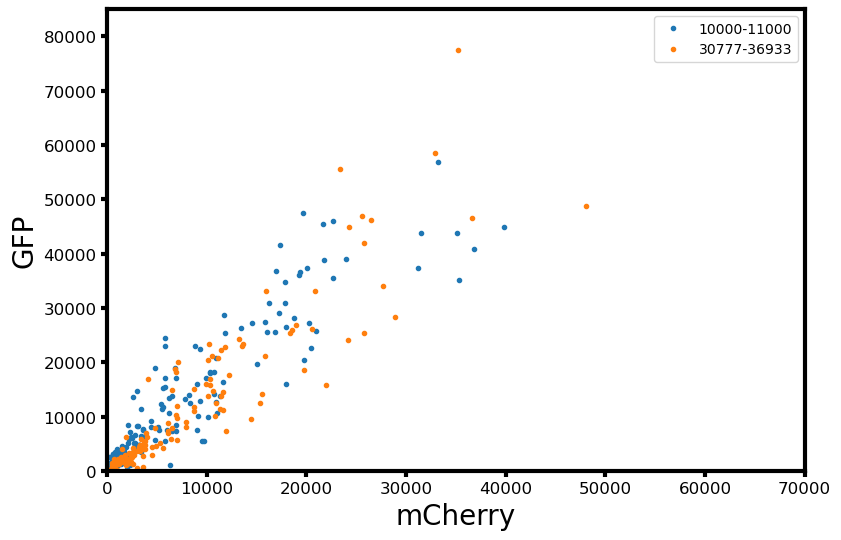

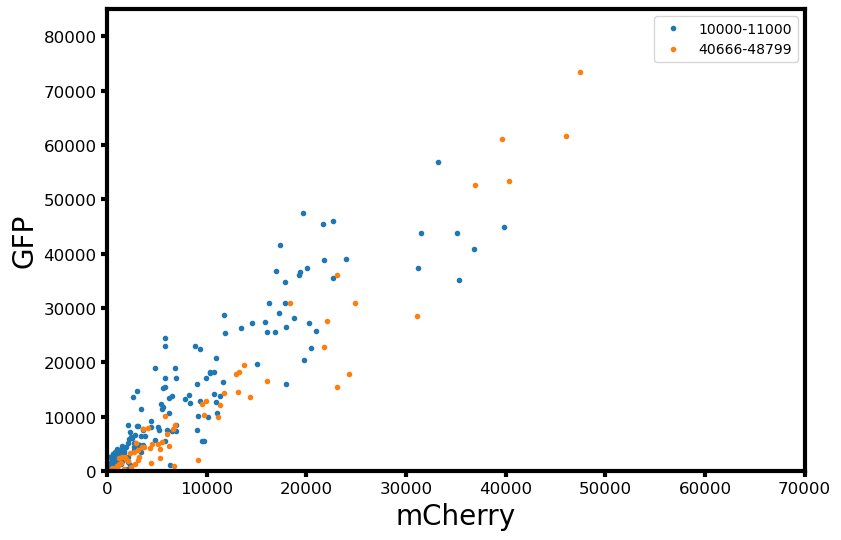

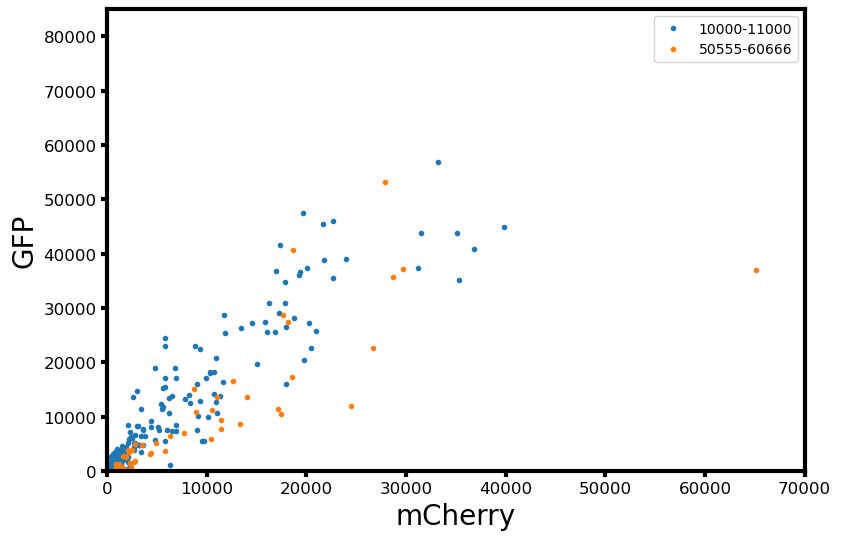

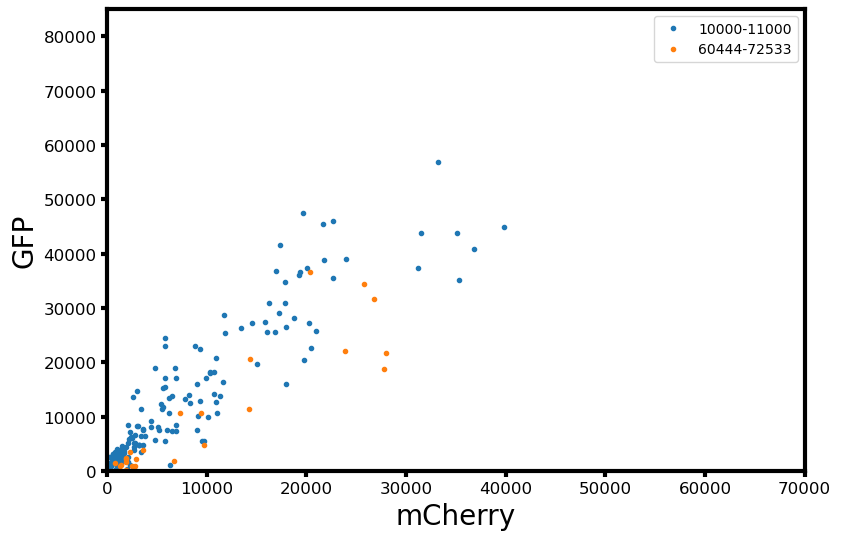

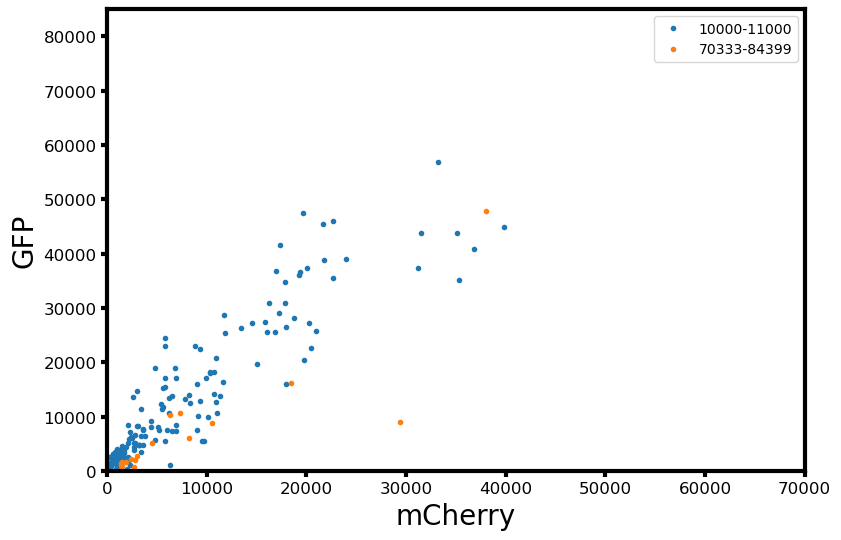

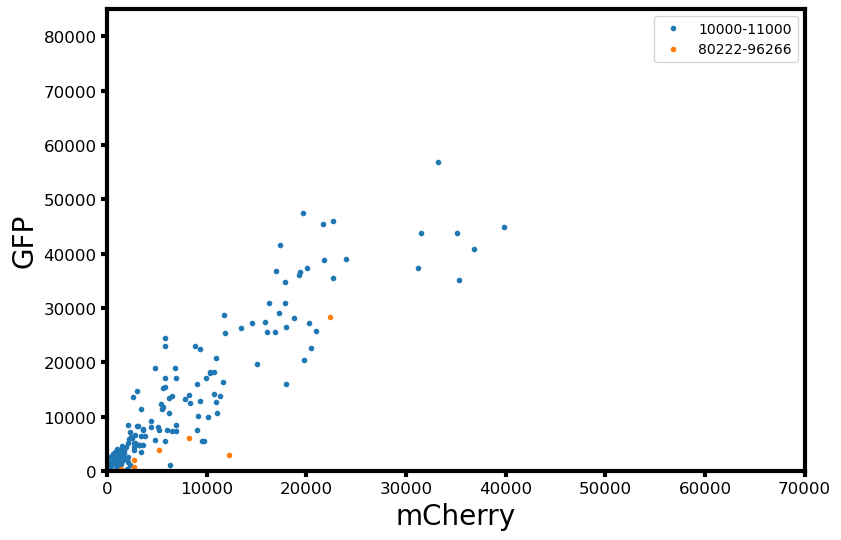

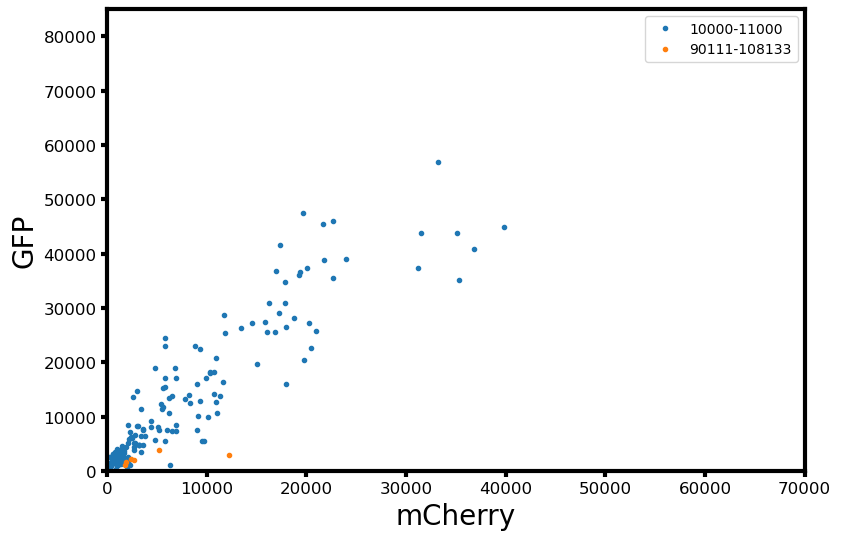

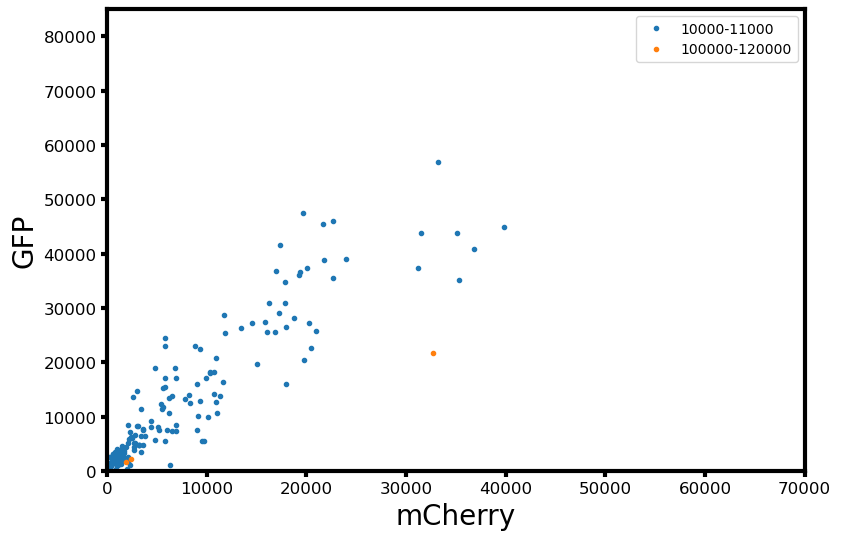

In [20]:
data = RAD1_plus_HUS1
x0, y0, z0 = cut_data(data, 10000, 11000)

for i in np.linspace(11000, 100000, 10):
    mi = i
    x, y, z = cut_data(data, mi, mi*1.2)
    scatter([x0, x], [y0, y], label=['10000-11000', '%d-%d'%(i, i*1.2)])

In [21]:
def linear_model(x, a):
    return a*x

def linear_fit(data1, mi, mx, fig=False):
    filter_data = cut_data(data1, mi, mx)
    rfp, gfp, bfp = filter_data
    fit_params, cov_mat = curve_fit(linear_model, rfp, gfp, p0 = [1])
    
    if fig == True:
        y = linear_model(rfp, fit_params[0])

        plt.plot(rfp, gfp, '.', label='data')
        plt.plot(rfp, y, '.', label='fit\nbfp=%d~%d'%(mi, mx))
        plt.xlim(0, 70000)
        plt.ylim(0, 85000)
        plt.legend()
        plt.show()
    return fit_params

def find_cutoff_by_slope(data, points, fig=False):
    slope_ls = []
    for i in points:
        try:
            mi = i
            slope = linear_fit(data, mi, mi*1.1, fig=fig)
            slope_ls.append(slope)
        except:
            pass
    length = len(slope_ls) 
    plt.plot(points[:length], slope_ls, 'o-')
    plt.show()
    p = points[slope_ls.index(max(slope_ls))]
    print(p)
    return p, max(slope_ls)/min(slope_ls)

def cal_percent(data, cutoff):
    total = len(data.bfp)
    select = len([i for i in data.bfp if i<=cutoff])
    
    return select/total*100

#### Rad1_Hus1 data

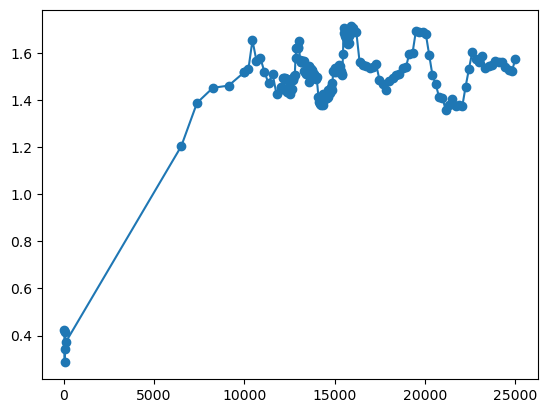

15922.448979591836


(15922.448979591836, array([5.98749384]))

In [22]:
data = RAD1_plus_HUS1
points1 = np.linspace(30, 100, 5)
points2 = np.linspace(6500, 10000, 5)
points3 = np.linspace(10000, 12000, 10)
points4 = np.linspace(12020, 14000, 50)
points6 = np.linspace(14100, 16000, 50)
points66 = np.linspace(16010, 25000, 50)
points8 = np.concatenate((points1, points2, points3, points4, points6, points66))

find_cutoff_by_slope(data, points8)

In [23]:
cal_percent(data, 16560.408163265307)

90.21706511953586

In [24]:
shift_data_and_update(data, cutoff=16560.408163265307)

#### Hus1_Rad1 data

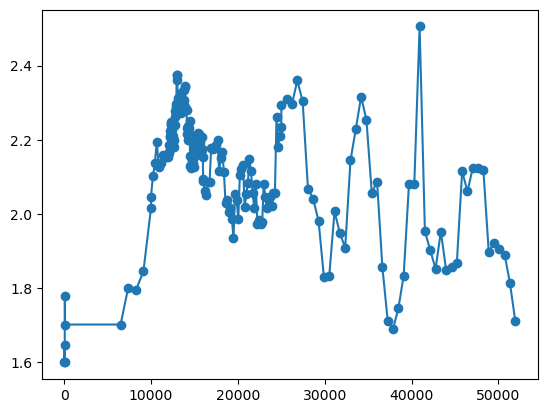

40923.06122448979


(40923.06122448979, array([1.56653677]))

In [25]:
data = HUS1_plus_RAD1
points1 = np.linspace(30, 100, 5)
points2 = np.linspace(6500, 10000, 5)
points3 = np.linspace(10000, 12000, 10)
points4 = np.linspace(12020, 14000, 50)
points6 = np.linspace(14100, 16000, 50)
points7 = np.linspace(16010, 25000, 50)
points77 = np.linspace(25010, 55000, 50)
points8 = np.concatenate((points1, points2, points3, points4, points6, points7, points77))
find_cutoff_by_slope(data, points8)

In [26]:
cal_percent(data, 22247.95918367347)

94.49834950485145

In [27]:
shift_data_and_update(HUS1_plus_RAD1, cutoff=22247.95918367347)

## III. Model Fitting

#### Compare the difference between RFP and BFP

/Users/klhsu/miniforge3/envs/py38_native/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/klhsu/miniforge3/envs/py38_native/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


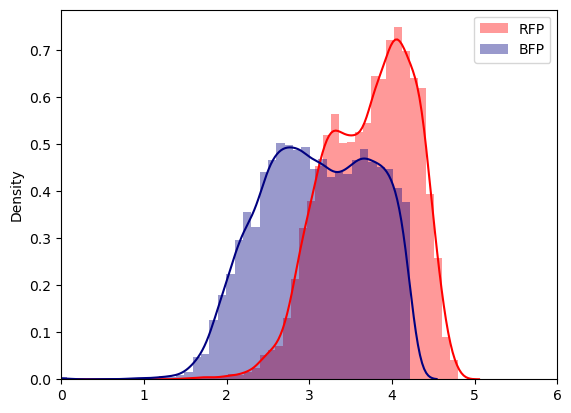

/Users/klhsu/miniforge3/envs/py38_native/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/klhsu/miniforge3/envs/py38_native/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


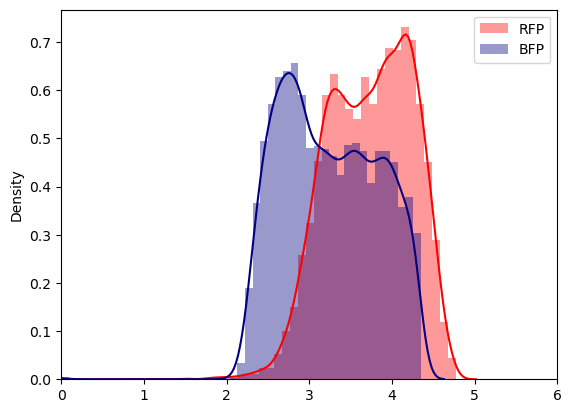

In [28]:
#Discrepancy between RFP and BFP
def RFP_BFP(data, log=True, n=1):
    rfp = data.rfp
    bfp = data.bfp*n
    rfp[rfp <= 0] = 1
    bfp[bfp <= 0] = 1
    if log == True:
        sns.distplot(np.log10(rfp), color='red', label='RFP')
        sns.distplot(np.log10(bfp), color='navy', label='BFP')
        
        plt.xlim(0, 6)
    else:
        sns.distplot(rfp[:100000], bins=100 ,kde=False,hist_kws={"range": [0, 50000], 'linewidth':0.1},color='red', label='RFP')
        sns.distplot(bfp[:100000], bins=100 ,kde=False,hist_kws={"range": [0, 50000], 'linewidth':0.1},color='navy', label='BFP')
    plt.legend()
    plt.show()

RFP_BFP(RAD1_plus_HUS1, log=True)
RFP_BFP(HUS1_plus_RAD1, log=True)

### Introduce the n factor for red and blue fluorescence correction into the model for fitting

In [29]:
def p1_plus_p3_n(cc, lam1, lam2, lam3, K, n):
    (c1, c2) = cc
    f = (K*c1*lam3 - K*(c2*n)*lam3 - lam1*lam2 + np.sqrt(K**2*c1**2*lam3**2 - 2*K**2*c1*(c2*n)*lam3**2 + K**2*(c2*n)**2*lam3**2 + 2*K*c1*lam1*lam2*lam3 + 2*K*(c2*n)*lam1*lam2*lam3 + lam1**2*lam2**2))*(K*c1*lam3 + 2*K*(c2*n)*lam1 - K*(c2*n)*lam3 + lam1*lam2 + np.sqrt(K**2*c1**2*lam3**2 - 2*K**2*c1*(c2*n)*lam3**2 + K**2*(c2*n)**2*lam3**2 + 2*K*c1*lam1*lam2*lam3 + 2*K*(c2*n)*lam1*lam2*lam3 + lam1**2*lam2**2))/(2*K*lam1*lam3*(K*c1*lam3 - K*(c2*n)*lam3 + lam1*lam2 + np.sqrt(K**2*c1**2*lam3**2 - 2*K**2*c1*(c2*n)*lam3**2 + K**2*(c2*n)**2*lam3**2 + 2*K*c1*lam1*lam2*lam3 + 2*K*(c2*n)*lam1*lam2*lam3 + lam1**2*lam2**2)))
    return f

def model_fitting_for_n(data):
    R, G, B = data.rfp, data.gfp, data.bfp
    c1 = R
    c2 = B
    p1p3 = G
    cc = [c1, c2]
    
    #generate a set of initial value for curve fitting
    ls1 = [0.1, 1, 10]
    x = y = z = w = s = ls1
    X, Y, Z, W, S= np.meshgrid(x, y, z, w, s)
    ini_1 = np.ravel(X)
    ini_2 = np.ravel(Y)
    ini_3 = np.ravel(Z)
    ini_4 = np.ravel(W)
    ini_5 = np.ravel(S)
    
    result = []
    #Curve fitting
    for i in range(len(ini_1)):
        try:
            init_vals = [ini_1[i], ini_2[i], ini_3[i], ini_4[i], ini_5[i]]
            fit_params, cov_mat = curve_fit(p1_plus_p3_n, cc, p1p3, p0 = init_vals, bounds=(0, [np.inf, np.inf, np.inf, np.inf, np.inf]))

            result.append(fit_params)
        except:
            pass
        
    return result

In [30]:
start = time.time()

data = RAD1_plus_HUS1

n_all_fit_result = []
n_all = []

n_fit_result = model_fitting_for_n(data)
n_res = np.array([i[4] for i in n_fit_result])
std = n_res.std()
med = np.median(n_res)
n_all.append(med)
n_all_fit_result.append(n_fit_result)
print(med, std)

end = time.time()
print(end-start)

2.1410723674598544 1.4122435441935384
148.55633211135864


In [31]:
Coor_stab_RAD1 = np.array([i[0]/i[2] for i in n_fit_result])
np.median(Coor_stab_RAD1)

5.157799261623643

In [32]:
start = time.time()

data = HUS1_plus_RAD1

n_all_fit_result_h = []
n_all_h = []

n_fit_result_h = model_fitting_for_n(data)
n_res_h = np.array([i[4] for i in n_fit_result_h])
std = n_res_h.std()
med = np.median(n_res_h)
n_all_h.append(med)
n_all_fit_result_h.append(n_fit_result_h)
print(med, std)

end = time.time()
print(end-start)

1.6031769592667562 1.871581234919147
119.00906872749329


In [33]:
Coor_stab_HUS1= np.array([i[0]/i[2] for i in n_fit_result_h])

In [34]:
print('The cooperative stability of RAD1: ',np.median(Coor_stab_RAD1))
print('The cooperative stability of HUS1: ',np.median(Coor_stab_HUS1))

The cooperative stability of RAD1:  5.157799261623643
The cooperative stability of HUS1:  7.7174907402005655
